# Import Packages

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
import os
from os.path import join, basename
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio 
import time
import pandas as pd
%matplotlib inline

In [4]:
from numpy.linalg import det, norm

In [5]:
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [36]:
imageio.plugins.ffmpeg.download()

# Build image process pipeline

In [47]:
class laneLineDetector:
    def __init__(self):
        """
        parameter for image processing
        """
        self.houghLine_para = { "rho": 1
                               , "theta": np.pi/180
                               , "threshold": 15
                               , "min_line_len": 35
                               , "max_line_gap": 2}
        self.canny_para = { "low_threshold": 50
                           , "high_threshold": 200}
        self.gaussian_blur_para = { "kernel_size": 7}
        
        """
        parameter from hough line filter
        """
        self.left_slope_upperbound = -0.4
        self.left_slope_lowerbound = -3.0

        self.right_slope_upperbound = 3.0
        self.right_slope_lowerbound = 0.4
        
        self.left_distance_upperbound = 300.0
        self.left_distance_lowerbound = 30.0 
        
        self.right_distance_upperbound = 300.0
        self.right_distance_lowerbound = 30.0
        
        """
        parameters for color filter
        """
        self.yellowLine_color_boundary = ([200,170,0], [255, 225, 150])
        self.WhiteLine_color_boundary = ([210,210,210], [255, 255, 255])

    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        Generating Hough Lines for lane line detection 
        """        
        # The first and second row are the coordinates of left point. 
        # The first one is x_left, and the second one is y_left.
        # The third and fourth row are the coordinates of right point. 
        # The third one is x_right, and the fourth one is y_right.
        return np.squeeze(cv2.HoughLinesP(img, rho, theta
                                          , threshold, np.array([])
                                          , minLineLength=min_line_len
                                          , maxLineGap=max_line_gap), axis=1)

    def line_extrapolation(self):
        # compute line slope
        left_slope = np.divide(self.left_lines[1] - self.left_lines[3]
                               , self.left_lines[0] - self.left_lines[2])
        right_slope = np.divide(self.right_lines[1] - self.right_lines[3]
                                , self.right_lines[0] - self.right_lines[2])
                
        # capture fitting lane lines based on the slope average of Hough lines
        # do lane line extrapolation 
        Lane_Y_lowerbound = int(self.img.shape[0] * 0.63)
        Lane_Y_upperbound = self.img.shape[0]

        # the weight is the square of line length
        left_weight = np.sqrt(np.sum(np.square([self.left_lines[1] - self.left_lines[3]
                                                , self.left_lines[0] - self.left_lines[2]]), axis = 0))
        right_weight = np.sqrt(np.sum(np.square([self.right_lines[1] - self.right_lines[3]
                                                 , self.right_lines[0] - self.right_lines[2]]), axis = 0))
        
        left_weighted_slope = np.sum(left_weight * left_slope) / np.sum(left_weight)
        right_weighted_slope = np.sum(right_weight * right_slope) / np.sum(right_weight)

        left_masscenter = left_weight * self.left_lines
        right_masscenter = right_weight * self.right_lines
        
        # Lemass center = (a,b) 
        # line formula: y-b = m * (x - a), m is slope
        # substitute Lane_Y_lowerbound, Lane_Y_upperbound into the equations and get Lane_X_lowerbound, Lane_X_upperbound
        
        left_weighted_masscenter = np.sum( np.stack((left_masscenter[0]+left_masscenter[2], left_masscenter[1]+left_masscenter[3]), axis=0), axis=1) / (np.sum(left_weight, axis=0)* 2)
        right_weighted_masscenter = np.sum( np.stack((right_masscenter[0]+right_masscenter[2], right_masscenter[1]+right_masscenter[3]), axis=0), axis=1) / (np.sum(right_weight, axis=0)* 2)
        
        # x = (y-b)/m + a
        return [((Lane_Y_upperbound - left_weighted_masscenter[1]) / left_weighted_slope + left_weighted_masscenter[0], Lane_Y_upperbound) # left_Lane_X_upperbound
                 ,((Lane_Y_lowerbound - left_weighted_masscenter[1]) / left_weighted_slope + left_weighted_masscenter[0], Lane_Y_lowerbound)  # left_Lane_X_lowerbound
                 ,((Lane_Y_upperbound - right_weighted_masscenter[1]) / right_weighted_slope + right_weighted_masscenter[0], Lane_Y_upperbound)  # right_Lane_X_upperbound
                 ,((Lane_Y_lowerbound - right_weighted_masscenter[1]) / right_weighted_slope + right_weighted_masscenter[0], Lane_Y_lowerbound)] # right_Lane_X_lowerbound
    
    def hough_line_filter(self, lines, distance_ftr = False):

        # calculate the slope and length of the lines for visualization
        self.slope = np.divide(lines[1]-lines[3], lines[0]-lines[2])
        right_condition = (self.slope >= self.right_slope_lowerbound) & (self.slope < self.right_slope_upperbound)
        left_condition = (self.slope >= self.left_slope_lowerbound) & (self.slope < self.left_slope_upperbound)
        """
        there are two points for each line. The line is probably the lane if it is too close in region-of-interest boundary. 
        """
        if distance_ftr:
            left_vec_diff = self.reference_points_left[0] - self.reference_points_left[1]
            right_vec_diff= self.reference_points_right[0] - self.reference_points_right[1]        

            # Each line segment has two points, P1 and P2. The distance of the line to the boundary is the average of distance between P1 and boundary, P2 and boundary 
            P1 = lines[:2,:].T
            P2 = lines[2:4, :].T
            # if the slope is positive, the distance is P1 to right boundary. If negative, he distance is P1 to left boundary 
            distance_to_P1 = np.where( self.slope >=.0
                             , abs(np.cross(P1 - self.reference_points_right[0], right_vec_diff)) / self.reference_points_distance
                             , abs(np.cross(P1 - self.reference_points_left[0], left_vec_diff)) / self.reference_points_distance)

            # if the slope is positive, the distance is P2 to right boundary. If negative, he distance is P1 to left boundary 
            distance_to_P2 = np.where( self.slope >=.0
                             , abs(np.cross(P2 - self.reference_points_right[0], right_vec_diff)) / self.reference_points_distance 
                             , abs(np.cross(P2 - self.reference_points_left[0], left_vec_diff)) / self.reference_points_distance) 
            self.distance = (distance_to_P1 + distance_to_P2)/2
            
            right_condition = right_condition & ((self.distance >= self.right_distance_lowerbound) & (self.distance < self.right_distance_upperbound))
            left_condition = left_condition & ((self.distance >= self.left_distance_lowerbound) & (self.distance < self.left_distance_upperbound))
        
        # there are two filters: filter based on slope and filter based on distance between detected Hough lines and boundaries. 
        # right lines filters: 
#         right_condition = (self.slope >= self.right_slope_lowerbound) & (self.slope < self.right_slope_upperbound)\
#                         & (self.distance >= self.right_distance_lowerbound) & (self.distance < self.right_distance_upperbound)
        self.right_lines = (lines[:,np.array(right_condition)])

        # left lines filter: 
#         left_condition = (self.slope >= self.left_slope_lowerbound) & (self.slope < self.left_slope_upperbound)\
#                         & (self.distance >= self.left_distance_lowerbound) & (self.distance < self.left_distance_upperbound)
                            
        self.left_lines = (lines[:,np.array(left_condition)])
        
        # if no line was picked after filtering, then pick line of the smallest slope for left line and line of the largest slope for right line
        if self.left_lines.shape[1] == 0:
            self.left_lines = lines[:,np.argmin(self.slope)].reshape(4,1)    
        if self.right_lines.shape[1] == 0:
            self.right_lines = lines[:,np.argmax(self.slope)].reshape(4,1)

        return self.right_lines, self.left_lines

    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    def canny(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(self, img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv2.fillPoly(mask, vertices, ignore_mask_color)

        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def weighted_img(self, initial_img, img, α=1.0, β=1.0, λ=0.):
        """
        initial_img * α + img * β + λ
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)

    def get_fitLineCharacter(self, x, y):
        """
        format is y = slope * x + intercept
        """
        slope, intercept, _, _, std_err = stats.linregress(x,y)
        return slope, intercept

    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=10):
        for x1, y1, x2, y2 in lines:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

    def draw_circle(self, img, center, radius, color, thickness = 5):
        cv2.circle(img, center, radius, color, thickness)

    def draw_triangle(self, img, vertex, color, thickness = 5):
        cv2.polylines(img, [vertex], True, color,thickness)
        
    def viz_line_features(self):
        """
        visualize the distribution of Hough line features
        """
        line_num = self.slope.shape[0]
        
        self.slope = np.reshape(self.slope, (1, line_num))
        self.distance = np.reshape(self.distance, (1, line_num))
            
        input_scatterPlot = np.concatenate((self.slope.T, self.distance.T), axis=1)        
        dataframe = pd.DataFrame(input_scatterPlot, columns=['Slope', 'Distance'])

        dataframe['lineSign'] = pd.Series(np.squeeze(np.where(self.slope >=.0, 'right', 'left'), axis=0))
        fig = ff.create_scatterplotmatrix(dataframe, diag='histogram', index='lineSign', height=800, width=800)
        plotly.offline.iplot(fig, filename='Box plots along Diagonal Subplots')

    def point_to_line_distance(self, A, B, P):
        """ 
        segment line AB, point P, where each one is an array([x, y]) 
        the angle lies in [-pi/2, pi/2].
        """
        if (A==B).all():
            return norm(P - A)
        else :
            return abs(np.cross(P - B, A - B) / norm(A - B))

    def show_img(self, img):
        cv2.namedWindow("Image")   
        cv2.imshow("Image", img)
        cv2.waitKey (0)  
        cv2.destroyAllWindows()  

    def color_of_interest(self, img, boundary):
        lower, upper = boundary
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors within the specified boundaries and apply
        # the mask
        mask = cv2.inRange(img, lower, upper)
        return cv2.bitwise_and(img, self.img,  mask= mask)
        
    def plot_color_distribution(self, elements, color, _alpha = 0.5, _size = 5, _dpi = 96, dim ='RB'):

        color_dict = {'R':0, 'G':1, 'B':2}
        color1 = color_dict[dim[0]]
        color2 = color_dict[dim[1]]

        plt.figure(figsize=(500/_dpi, 500/_dpi), dpi=_dpi)
        plt.axis([0, 1, 0, 1])
        plt.axes([0.0, 0.0, 1, 1])
        plt.scatter(elements[:,color1],elements[:,color2], s=_size, c=color, alpha=_alpha)
        
        plt.xlabel(dim[0])
        plt.ylabel(dim[1])
        plt.title(dim + ' distribution')

        plt.xlim(min(elements[:,color1]), max(elements[:,color1]))
        plt.ylim(min(elements[:,color2]), max(elements[:,color2]))
        
        plt.savefig('color_distribution//'+dim+'_distribution.png')
        return
           
    def color_filterprocess_image(self, img):
        """
        the main pipeline for lane line detection
        """
        self.img = img
        self.img_size = img.shape
        self.left_slope_upperbound = -0.27
        self.left_slope_lowerbound = -10.0

        self.right_slope_upperbound = 10.0
        self.right_slope_lowerbound = 0.27
        
        # points for calculating the point-to-line distance
        self.reference_points_right = np.array([[self.img_size[1]//2, self.img_size[0]//2]
                                                , [self.img_size[1], self.img_size[0]]])                      # np.array([[480, 270], [960, 540]])
        self.reference_points_left = np.array([[self.img_size[1]//2, self.img_size[0]//2]
                                               , [0 ,self.img_size[0]]])                                     # np.array([[480, 270], [0, 540]])    
        self.reference_points_distance = norm(self.reference_points_right[0] - self.reference_points_right[1])   
        
        # points for fetching region of interest
        self.auxiliary_points = np.array([[(0,self.img_size[0]),(self.img_size[1]//2, self.img_size[0]//2), (self.img_size[1],self.img_size[0])]], dtype=np.int32)
        
        # capture the region of interest
        self.masked_img = self.region_of_interest(self.img, self.auxiliary_points)
        
        # tranform image from (height, width, 3) to (height * width, 3)
        self.non_black_elements = self.masked_img[self.masked_img.any(axis=-1)]  
        self.color = self.non_black_elements/255
        self.yellowLine_img = self.color_of_interest(self.masked_img, self.yellowLine_color_boundary)
        self.whiteLine_img = self.color_of_interest(self.masked_img, self.WhiteLine_color_boundary)
        
        self.blend_img = self.weighted_img(self.yellowLine_img, self.whiteLine_img)        
        
        # output an image with only one color channel
        self.gray_image = self.grayscale(self.blend_img)
        
        # canny transformation
        self.canny_img = self.canny(self.gray_image , self.canny_para["low_threshold"], self.canny_para["high_threshold"])
        
        # filter for Gaussian smoothing 
        self.gaussian_blur_para = { "kernel_size": 5}
        self.blurred_img = self.gaussian_blur(self.canny_img, self.gaussian_blur_para["kernel_size"])

        self.houghLine_para = { "rho": 1, "theta": np.pi/180, "threshold": 15, "min_line_len": 25, "max_line_gap": 2}
        # hough line generation
        houghLines = self.hough_lines(self.blurred_img
                                   , self.houghLine_para["rho"]
                                   , self.houghLine_para["theta"]
                                   , self.houghLine_para["threshold"]
                                   , self.houghLine_para["min_line_len"]
                                   , self.houghLine_para["max_line_gap"]) 
        
        # separate Hough lines into left lines and right lines. 
        # search (1) the leftmost point of right Hough lines and (2) the rightmost point of left Hough lines
        self.right_lines, self.left_lines = self.hough_line_filter(houghLines.T)
        [(left_upper_x1,left_upper_y1), (left_lower_x1,left_lower_y1), (right_upper_x1,right_upper_y1), (right_lower_x1,right_lower_y1)] = self.line_extrapolation()
        
        # draw lane lines after extrapolation 
        self.draw_lines(self.img
                        , [[left_upper_x1,left_upper_y1, left_lower_x1,left_lower_y1]
                        ,[right_upper_x1,right_upper_y1, right_lower_x1,right_lower_y1]]
                        ,color=[255, 0, 255]
                        , thickness=8)

        return self.img

# Test on images

In [44]:
def Output_img(out_path, img):
    cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))     

In [46]:
color_selector_obj = laneLineDetector()

in_path = join('test_images', 'test.jpg')
in_image = cv2.cvtColor(cv2.imread(in_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

in_image_cp = np.copy(in_image)
out_image = color_selector_obj.color_filterprocess_image(in_image_cp)

out_path = join('test_images_output', 'test.jpg')
Output_img(out_path, out_image)

# Test on videos

In [48]:
color_selector_obj = laneLineDetector()

test_videos_dir = 'test_videos'
test_videos = [join(test_videos_dir, name) for name in os.listdir(test_videos_dir)]
for test_video in test_videos:
    print('Processing video: {}'.format(test_video))
    cap = cv2.VideoCapture(test_video)  
    
    # get video frame size
    width, height = 0, 0
    if cap.isOpened(): 
        width = int(cap.get(3))
        height = int(cap.get(4)) 
    
    # initialize video writer object
    out_Video = cv2.VideoWriter(join('test_videos_output', "colorFilter_" + basename(test_video)),
                      fourcc=cv2.VideoWriter_fourcc(*'DIVX'),
                      fps=24.0, frameSize=(width, height))
    in_image = None
    a = 0
    try:
        while cap.isOpened():
            # cap.read() returns a bool (True/False). If frame is read correctly, it will be True. End of the video can be checked with this return value.
            ret, color_frame = cap.read()
            if ret:
                a+=1
                in_image = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
                in_image_cp = np.copy(in_image)
                out_image = color_selector_obj.color_filterprocess_image(in_image_cp)
                out_Video.write(cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR))     
            else:
                break
        print ("transform ends")        
    except ValueError as e:    
        print ("ValueError:" + str(e))

    except IndexError as e:
        print ("IndexError:" + str(e))
    finally:
        cap.release()
        out_Video.release()
        cv2.destroyAllWindows()

Processing video: test_videos\challenge.mp4
transform ends
Processing video: test_videos\solidWhiteRight.mp4
transform ends
Processing video: test_videos\solidYellowLeft.mp4
transform ends


# Visualize useful line features

In [23]:
color_selector_obj.viz_line_features()   

# Visualize color feature distribution

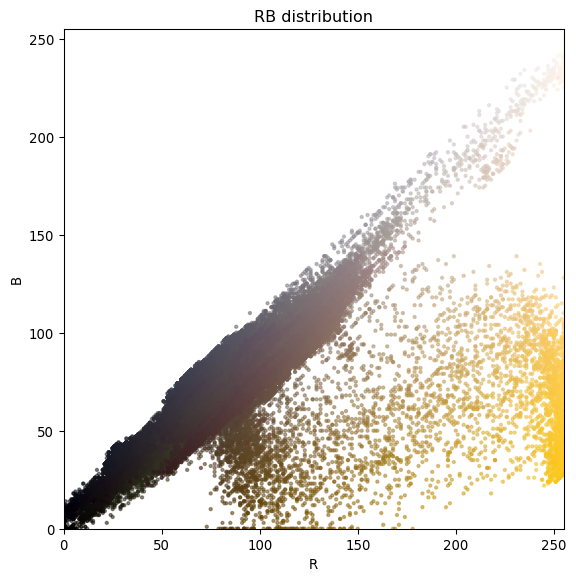

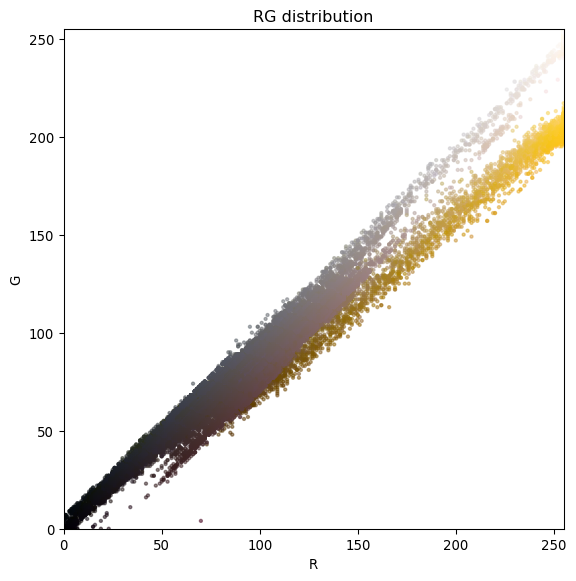

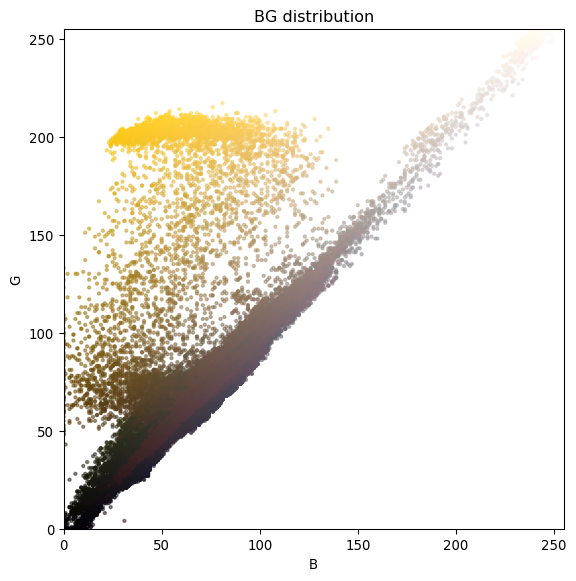

In [34]:
color_selector_obj.plot_color_distribution(elements = color_selector_obj.non_black_elements, color = color_selector_obj.color, dim ='RB')
color_selector_obj.plot_color_distribution(elements = color_selector_obj.non_black_elements, color = color_selector_obj.color, dim ='RG')
color_selector_obj.plot_color_distribution(elements = color_selector_obj.non_black_elements, color = color_selector_obj.color, dim ='BG')

In [13]:
"""
Double the {{ and }} to print literal curly-brace characters in python string
"""

grad_Colors = {"left_R": 225, "left_G": 180, "left_B":0, "right_R":255, "right_G":225, "right_B":100}
HTML("""
<head>
<style>
#grad1 {{
    height: 200px;
    background: red;
    background: linear-gradient(to right, rgba({left_R}, {left_G}, {left_B}, 1) , rgba({right_R}, {right_G}, {right_B}, 1));}}
</style>
</head>
<body>
<h1>Linear Gradient test</h1>
<p>This linear gradient starts at the left. It starts first color, transitioning to second color:</p>
<div id="grad1"></div>
</body>""".format(**grad_Colors))